# Using quantum kernel - Method 1

- Purpose
    - Build and evaluate a quantum-inspired kernel classifier to distinguish pure vs mixed qubit states using Bloch-vector fidelity as a kernel.

- Data preparation
    - Dataset created with `build_purity_classification_dataset(...)` (columns include `X_mean`, `Y_mean`, `Z_mean` and label `label_purity`).
    - Default parameters used in many cells: `N_SHOTS = 1000`, `n_states_total = 5000`, `mixed_proportion = 0.5`.
    - Printed dataset shape and label distribution for sanity checks.

- Kernel implementation
    - `compute_bloch_fidelity_kernel(R_A, R_B=None)` computes pairwise fidelity between Bloch vectors in a fully vectorized way.
    - Uses dot products and determinant-like sqrt term; applies `np.clip` to avoid sqrt of negative values (numerical stability).
    - Returns symmetric train kernel or rectangular test-vs-train kernel.

- Model training & evaluation
    - Use only Bloch vectors (`X_mean`, `Y_mean`, `Z_mean`) as features.
    - Train/test split: `train_test_split(..., test_size=0.2, random_state=42)`.
    - SVM (`sklearn.svm.SVC`) with `kernel='precomputed'` and `C=1.0` trained on the computed kernel matrix.
    - Evaluation: accuracy, per-class F1 scores, classification report and confusion matrix; printed kernel shapes and test accuracy.

- Experiments performed
    - Varying mixed-state proportion: `proportion = [0.1, ..., 0.9]` — compute metrics and plot accuracy & F1 vs proportion.
    - Varying dataset size: `n_states = [100, 200, 500, 1000, 2000, 5000]` — compute metrics and plot performance vs dataset size.
    - Varying number of shots: `n_shots = [10, 50, 100, 500, 1000, 5000]` — compute metrics and plot performance vs shots (plots use semilog x-axis).

- Visualization
    - Plots produced for accuracy and per-class F1 scores across the three experimental axes (mixed proportion, dataset size, number of shots). Grids, legends and axis limits set for readability.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from clf_dtSet_hugo import build_purity_classification_dataset

In [3]:
N_SHOTS = 1000

df_purity, X, y = build_purity_classification_dataset(
    n_shots=N_SHOTS,
    n_states_total=5000,
    mixed_proportion=0.5  # proportion of mixed states
)

print(f"Dataset shape: {df_purity.shape}")
print(f"Labels distribution:\n{y.value_counts()}")
print(f"\nDataset columns:\n{df_purity.columns.tolist()}")
print(f"\X columns (à revoir):\n{X.columns.tolist()}")

df_purity.head()

Dataset shape: (5000, 14)
Labels distribution:
label_purity
0    2500
1    2500
Name: count, dtype: int64

Dataset columns:
['X_mean', 'Y_mean', 'Z_mean', 'X_real', 'Y_real', 'Z_real', 'theta_ideal', 'phi_ideal', 'X_ideal', 'Y_ideal', 'Z_ideal', 'bloch_radius_real', 'is_pure', 'label_purity']
\X columns (à revoir):
['X_mean', 'Y_mean', 'Z_mean', 'bloch_radius_real']


,X_mean,Y_mean,Z_mean,X_real,Y_real,Z_real,theta_ideal,phi_ideal,X_ideal,Y_ideal,Z_ideal,bloch_radius_real,is_pure,label_purity
0,0.072,-0.084,0.252,0.110576,-0.002973,0.263765,0.268489,6.266155,0.265236,-0.004517,0.964173,0.286021,False,0
1,0.410,-0.764,0.368,0.449138,-0.803892,0.389914,1.170258,5.221891,0.449138,-0.803892,0.389914,1.000000,True,1
2,-0.268,0.278,-0.244,-0.230418,0.265502,-0.254829,1.938624,2.218568,-0.563049,0.744090,-0.359590,0.434190,False,0
3,-0.266,0.312,0.370,-0.183112,0.310517,0.305010,0.896942,2.131335,-0.415437,0.661841,0.624002,0.472209,False,0
4,0.158,0.070,-0.228,0.178901,0.064552,-0.261387,2.575545,0.336128,0.506288,0.176891,-0.844027,0.323258,False,0


In [4]:
def compute_bloch_fidelity_kernel(R_A, R_B=None):
    """
    Compute the kernel matrix based on quantum fidelity between Bloch vectors,
    implemented in a fully vectorized way (no Python loops).

    Arguments:
        R_A : array (N, 3) - Bloch vectors of the first set (e.g., Train)
        R_B : array (M, 3) - Bloch vectors of the second set (e.g., Test).
              If None, compute the symmetric matrix R_A vs R_A.

    Returns:
        K : array (N, M) - Fidelity matrix
    """
    # If R_B is not provided, compute the square symmetric matrix (Train vs Train)
    if R_B is None:
        R_B = R_A

    # 1. Dot product for all pairs (r . s): (N,3) @ (3,M) -> (N,M)
    dot_product_matrix = np.dot(R_A, R_B.T)
    
    # 2. Squared norms (||r||^2 and ||s||^2)
    # axis=1 sums x^2 + y^2 + z^2 for each row
    r_sq_A = np.sum(R_A**2, axis=1)  # Shape (N,)
    r_sq_B = np.sum(R_B**2, axis=1)  # Shape (M,)
    
    # 3. Determinant-like term: sqrt((1 - r^2)(1 - s^2))
    # Use np.clip for numerical stability: noisy data may yield r^2 > 1
    factor_A = np.sqrt(np.clip(1 - r_sq_A, 0, None))
    factor_B = np.sqrt(np.clip(1 - r_sq_B, 0, None))
    
    # Outer product to form an (N, M) matrix of these factors
    det_term_matrix = np.outer(factor_A, factor_B)
    
    # 4. Final fidelity formula (vectorized)
    # F = 0.5 * (1 + (r . s) + sqrt_term)
    K = 0.5 * (1 + dot_product_matrix + det_term_matrix)
    
    return K

In [5]:
# 1. Extract Bloch vectors (columns 'X_mean', 'Y_mean', 'Z_mean') from the DataFrame
cols_bloch = ['X_mean', 'Y_mean', 'Z_mean']
bloch_vectors = df_purity[cols_bloch].values  # Convert to numpy array (N_samples, 3)
labels = df_purity['label_purity'].values     # Labels for the SVM

# 2. Train / Test split (we split the vectors directly)
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
    bloch_vectors, labels, test_size=0.2, random_state=42
)

# 2. Split Train / Test
# On splitte les vecteurs directement
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
    bloch_vectors, labels, test_size=0.2, random_state=42
)

In [6]:
# 3. Compute kernels (vectorized and fast)
print("Computing Train kernel...")
K_train = compute_bloch_fidelity_kernel(X_train_vec)

print("Computing Test kernel...")
K_test = compute_bloch_fidelity_kernel(X_test_vec, X_train_vec)

print(f"Shape K_train: {K_train.shape}")
print(f"Shape K_test: {K_test.shape}")

# Train SVC with precomputed kernel and evaluate
svc = SVC(kernel="precomputed", C=1.0)
svc.fit(K_train, y_train)
y_pred = svc.predict(K_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Computing Train kernel...
Computing Test kernel...
Shape K_train: (4000, 4000)
Shape K_test: (1000, 4000)
Test accuracy: 0.9670

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       487
           1       0.95      0.99      0.97       513

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

Confusion matrix:
[[458  29]
 [  4 509]]


Training SVC models with different parameters

In [7]:
# First we vary the proportion of mixed states from 0.1 to 0.9
df_array = []
accs = []
f1_score_0 = []
f1_score_1 = []

proportion = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in range(1,10):
    df_purity, X, y = build_purity_classification_dataset(
    n_shots=N_SHOTS,
    n_states_total=5000,
    mixed_proportion=i*0.1  # proportion of mixed states
    )
    
    df_array.append(df_purity)


for df in df_array:
    cols_bloch = ['X_mean', 'Y_mean', 'Z_mean']
    bloch_vectors = df[cols_bloch].values  
    labels = df['label_purity'].values    

    X_train_vec, X_test_vec, y_train, y_test = train_test_split(
        bloch_vectors, labels, test_size=0.2, random_state=42
    )
    
    K_train = compute_bloch_fidelity_kernel(X_train_vec)
    K_test = compute_bloch_fidelity_kernel(X_test_vec, X_train_vec)
    
    svc = SVC(kernel="precomputed", C=1.0)
    svc.fit(K_train, y_train)

    y_pred  = svc.predict(K_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    accs.append(acc)

    f1_scores = f1_score(y_test, y_pred, average=None)
    
    f1_score_0.append(f1_scores[0])
    f1_score_1.append(f1_scores[1])

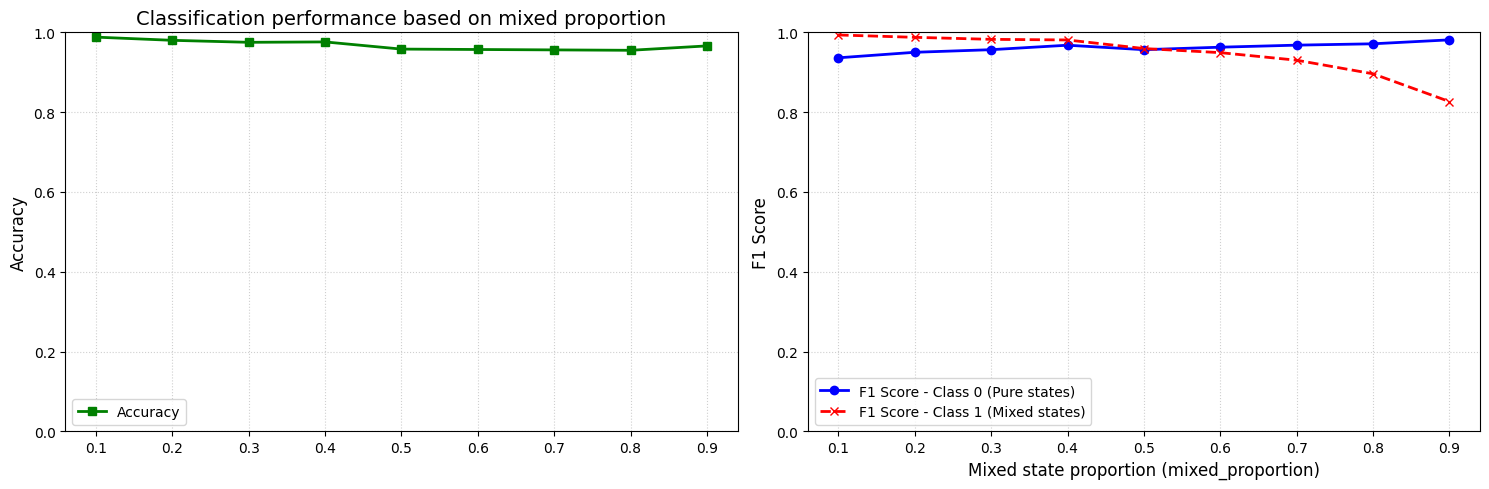

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True) 

ax1.plot(proportion, accs, 
         marker='s', linestyle='-', color='green', linewidth=2, 
         label='Accuracy')

ax1.set_title("Classification performance based on mixed proportion", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend(loc='lower left')
ax1.set_ylim(0, 1.0) 

ax2.plot(proportion, f1_score_0, 
         marker='o', linestyle='-', color='blue', linewidth=2, 
         label='F1 Score - Class 0 (Pure states)')
ax2.plot(proportion, f1_score_1, 
         marker='x', linestyle='--', color='red', linewidth=2, 
         label='F1 Score - Class 1 (Mixed states)')

ax2.set_ylabel("F1 Score", fontsize=12)
ax2.set_xlabel("Mixed state proportion (mixed_proportion)", fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend(loc='lower left')
ax2.set_ylim(0, 1.0) 

plt.tight_layout()

plt.show()

In [9]:
# Now we vary the number of states from 100 to 5000
df_array = []
accs = []
f1_score_0 = []
f1_score_1 = []

n_states = [100, 200, 500, 1000, 2000, 5000]

for nstate in n_states:
    df_purity, X, y = build_purity_classification_dataset(
    n_shots=N_SHOTS,
    n_states_total=nstate,
    mixed_proportion=0.5  # proportion of mixed states
    )
    
    df_array.append(df_purity)


for df in df_array:
    cols_bloch = ['X_mean', 'Y_mean', 'Z_mean']
    bloch_vectors = df[cols_bloch].values 
    labels = df['label_purity'].values    

    X_train_vec, X_test_vec, y_train, y_test = train_test_split(
        bloch_vectors, labels, test_size=0.2, random_state=42
    )
    
    K_train = compute_bloch_fidelity_kernel(X_train_vec)
    K_test = compute_bloch_fidelity_kernel(X_test_vec, X_train_vec)
    
    svc = SVC(kernel="precomputed", C=1.0)
    svc.fit(K_train, y_train)

    y_pred  = svc.predict(K_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    accs.append(acc)

    f1_scores = f1_score(y_test, y_pred, average=None)
    
    f1_score_0.append(f1_scores[0])
    f1_score_1.append(f1_scores[1])

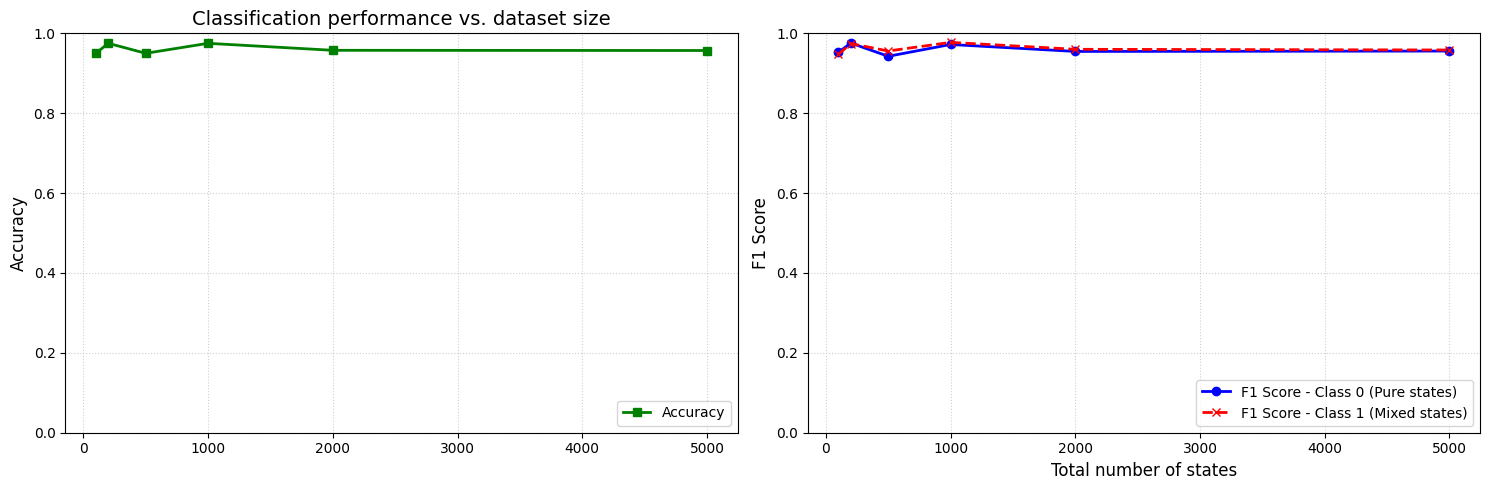

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True) 

ax1.plot(n_states, accs, 
         marker='s', linestyle='-', color='green', linewidth=2, 
         label='Accuracy')

ax1.set_title("Classification performance vs. dataset size", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.0) 

ax2.plot(n_states, f1_score_0, 
         marker='o', linestyle='-', color='blue', linewidth=2, 
         label='F1 Score - Class 0 (Pure states)')
ax2.plot(n_states, f1_score_1, 
         marker='x', linestyle='--', color='red', linewidth=2, 
         label='F1 Score - Class 1 (Mixed states)')
ax2.set_ylabel("F1 Score", fontsize=12)
ax2.set_xlabel("Total number of states", fontsize=12) 
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend(loc='lower right')
ax2.set_ylim(0, 1.0) 

plt.tight_layout() 

plt.show()

In [11]:
# Now we vary the number of shots from 10 to 5000
df_array = []
accs = []
f1_score_0 = []
f1_score_1 = []

n_shots = [10, 50, 100, 500, 1000, 5000]

for nshot in n_shots:
    df_purity, X, y = build_purity_classification_dataset(
    n_shots=nshot,
    n_states_total=5000,
    mixed_proportion=0.5  # proportion of mixed states
    )
    
    df_array.append(df_purity)


for df in df_array:
    cols_bloch = ['X_mean', 'Y_mean', 'Z_mean']
    bloch_vectors = df[cols_bloch].values  
    labels = df['label_purity'].values    

    X_train_vec, X_test_vec, y_train, y_test = train_test_split(
        bloch_vectors, labels, test_size=0.2, random_state=42
    )
    
    K_train = compute_bloch_fidelity_kernel(X_train_vec)
    K_test = compute_bloch_fidelity_kernel(X_test_vec, X_train_vec)
    
    svc = SVC(kernel="precomputed", C=1.0)
    svc.fit(K_train, y_train)

    y_pred  = svc.predict(K_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    accs.append(acc)

    f1_scores = f1_score(y_test, y_pred, average=None)
    
    f1_score_0.append(f1_scores[0])
    f1_score_1.append(f1_scores[1])

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


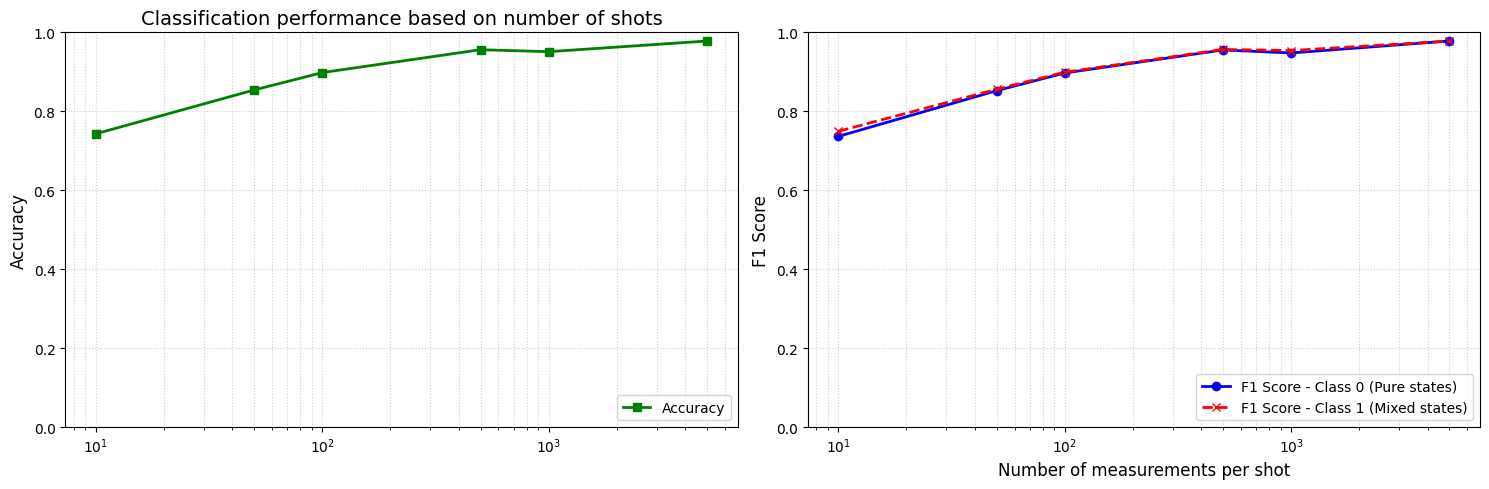

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True) 

ax1.semilogx(n_shots, accs, 
             marker='s', linestyle='-', color='green', linewidth=2, 
             label='Accuracy')

ax1.set_title("Classification performance based on number of shots", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, which="both", linestyle=':', alpha=0.6) 
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.0) 

ax2.semilogx(n_shots, f1_score_0, 
             marker='o', linestyle='-', color='blue', linewidth=2, 
             label='F1 Score - Class 0 (Pure states)')

ax2.semilogx(n_shots, f1_score_1, 
             marker='x', linestyle='--', color='red', linewidth=2, 
             label='F1 Score - Class 1 (Mixed states)')
ax2.set_ylabel("F1 Score", fontsize=12)
ax2.set_xlabel("Number of measurements per shot", fontsize=12) 
ax2.grid(True, which="both", linestyle=':', alpha=0.6)
ax2.legend(loc='lower right')
ax2.set_ylim(0, 1.0) 

plt.tight_layout() 

plt.show()